In [1]:
##imports

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pydataset import data
import statistics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import sklearn
import prepare
import acquire

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', 500)


First I acquire and do basic prep work on the data for processing

In [2]:
# calls prepare.py and utilized the prep_telco() function to return a prepared
# dataframe for telco, this automatically calls the acquire.py for acquisition
# of the csv and cleans/encodes the data for ease of processing/analysis
# then i have it run info and describe to manual review the information for any
# unusual data types or unexpected entries
prepare_df = prepare.prep_telco()
prepare_df.info(),prepare_df.describe(),prepare_df.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            7043 non-null   object 
 1   senior_citizen                         7043 non-null   int64  
 2   tenure                                 7043 non-null   int64  
 3   monthly_charges                        7043 non-null   float64
 4   total_charges                          7043 non-null   float64
 5   gender_encoded                         7043 non-null   int64  
 6   partner_encoded                        7043 non-null   int64  
 7   dependents_encoded                     7043 non-null   int64  
 8   phone_service_encoded                  7043 non-null   int64  
 9   paperless_billing_encoded              7043 non-null   int64  
 10  churn_encoded                          7043 non-null   int64  
 11  mult

(None,
        senior_citizen       tenure  monthly_charges  total_charges  \
 count     7043.000000  7043.000000      7043.000000    7043.000000   
 mean         0.162147    32.371149        64.761692    2279.734304   
 std          0.368612    24.559481        30.090047    2266.794470   
 min          0.000000     0.000000        18.250000       0.000000   
 25%          0.000000     9.000000        35.500000     398.550000   
 50%          0.000000    29.000000        70.350000    1394.550000   
 75%          0.000000    55.000000        89.850000    3786.600000   
 max          1.000000    72.000000       118.750000    8684.800000   
 
        gender_encoded  partner_encoded  dependents_encoded  \
 count     7043.000000      7043.000000         7043.000000   
 mean         0.495244         0.483033            0.299588   
 std          0.500013         0.499748            0.458110   
 min          0.000000         0.000000            0.000000   
 25%          0.000000         0.0000

i split my data to prevent contamination of analysis (validate/test)
then i find my baseline for referencing when i do modeling later

In [3]:
# sets my feature i want to predict/focus on
# splits my data twice with stratification on prediction feature
# returns the shapes for quick review

prediction_col = "churn_encoded"

train_df,test_df,validate_df = prepare.split_function(prepare_df.drop(columns=["customer_id"]),prediction_col)


prepared df shape: (7043, 31)
train shape: (4225, 31)
validate shape: (1409, 31)
test shape: (1409, 31)


In [4]:
##seperation of  data into easy referencing dataframes and lists (churned and unchurned. numbers and categories)

train_churned_df = train_df[train_df["churn_encoded"] == 1]
train_unchurned_df = train_df[train_df["churn_encoded"] == 0]

num_vars = []
cat_vars = []
for column in train_df:
    col_type =  train_df[column].dtype
    if col_type == "object":
        cat_vars.append(column)
    if col_type in ["int64", "uint8"] and ((train_df[column].max() + 1) / train_df[column].nunique())  == 1 :
        cat_vars.append(column)
    if col_type in ["float64", "int64", "uint8"] and \
        ((train_df[column].max() + 1) / train_df[column].nunique()) != 1 :
        num_vars.append(column)
print(num_vars,cat_vars)



['monthly_charges', 'total_charges'] ['senior_citizen', 'tenure', 'gender_encoded', 'partner_encoded', 'dependents_encoded', 'phone_service_encoded', 'paperless_billing_encoded', 'churn_encoded', 'multiple_lines_No phone service', 'multiple_lines_Yes', 'online_security_No internet service', 'online_security_Yes', 'online_backup_No internet service', 'online_backup_Yes', 'device_protection_No internet service', 'device_protection_Yes', 'tech_support_No internet service', 'tech_support_Yes', 'streaming_tv_No internet service', 'streaming_tv_Yes', 'streaming_movies_No internet service', 'streaming_movies_Yes', 'contract_type_One year', 'contract_type_Two year', 'internet_service_type_Fiber optic', 'internet_service_type_None', 'payment_type_Credit card (automatic)', 'payment_type_Electronic check', 'payment_type_Mailed check']


let's ask some questions of the data


> - **Hypothesis 1 -**
> - alpha = .05
> - $H_0$: Is churn independant of payment type. $\mu_{churn}$ independent $\mu_{payment type}$ (pval > alpha).  
> - $H_a$: Rejection of Null $\mu_{virginica}$ ~~independent~~  $\mu_{versicolor}$ (pval <= alpha). 


In [5]:
# creates a column of the payments for easy analysis, runs a crosstab to put into a chi2 independancy test.
# produces observed and expected values
# returns the chi2 and pval for the whole set

train_df["payments"] = np.where(train_df['payment_type_Credit card (automatic)'] == 1, "Credit_card", \
                                np.where(train_df['payment_type_Electronic check'] == 1, "Electronic_check", \
                                    np.where(train_df['payment_type_Mailed check'] == 1, "Mailed_check","Bank_Transfer")))

df1 = pd.crosstab(train_df.churn_encoded,train_df["payments"])
alpha = .05
chi2, p, degf, expected = stats.chi2_contingency(df1)
H0 = (f"{df1.index.name} is independant of {df1.columns.name}")
H1 = (f"{df1.index.name} is not independant of {df1.columns.name}")
print('Observed')
print(df1.values)
print('---\nExpected')
print(expected)
print(f'---\nchi^2 = {chi2:.4f}, p = {p:.5f}, degf = {degf}')
if p>alpha:
    print(f"due to p={p:.5f} > α={alpha} we fail to reject our null hypothesis\n({H0})")
else:
    print(f"due to p = {p:.5f} < α = {alpha} we reject our null hypothesis\n( ", '\u0336'.join(H0) + '\u0336' , ")")


Observed
[[789 774 780 761]
 [144 145 643 189]]
---
Expected
[[ 685.45136095  675.16591716 1045.44189349  697.9408284 ]
 [ 247.54863905  243.83408284  377.55810651  252.0591716 ]]
---
chi^2 = 388.9740, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  c̶h̶u̶r̶n̶_̶e̶n̶c̶o̶d̶e̶d̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶p̶a̶y̶m̶e̶n̶t̶s̶ )


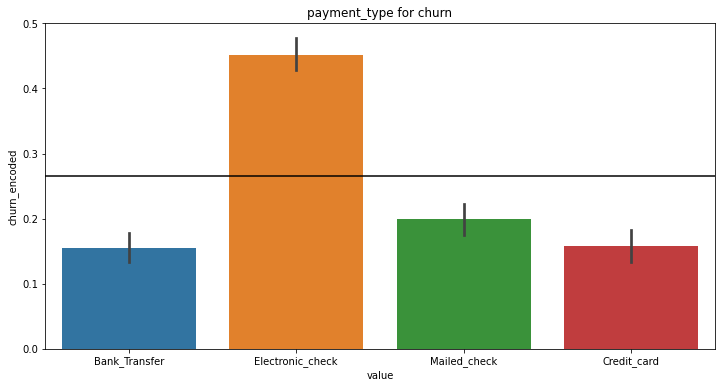

In [6]:
#creates a melt dataframe on payments for churn and charts it
melt_list = ["payments","churn_encoded"]
melt = train_df[melt_list]
melt = melt.melt(id_vars="churn_encoded")
plt.figure(figsize=(12,6))
sns.barplot(x=melt.value, y=melt.churn_encoded,)
plt.title("payment_type for churn")
plt.axhline(train_df.churn_encoded.mean(), label="Mean line",color="black")
plt.show()

> - Outcome: All payments failed in the Chi^2 statistical test to pass the null hypothesis of being independant of churn. this would indicate that there's a relation 

> - **Hypothesis 2 -** 
> - alpha = .025
> - $H_0$: Is monthly payment greater for those who churned and than those who have not churn $\mu_{monthly payment (churned)} <= \mu_{monthly payment (retained)}$.  
> - $H_a$: Rejection of null $\mu_{monthly payment (churned)} > \mu_{monthly payment (retained)}$. 
> - Outcome: outcome.

we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=191.12029, p=0.00000
We reject the null Hypothesis ( m̶o̶n̶t̶h̶l̶y̶ ̶p̶a̶y̶m̶e̶n̶t̶s̶ ̶o̶f̶ ̶c̶h̶u̶r̶n̶e̶d̶ ̶i̶s̶ ̶l̶e̶s̶s̶ ̶t̶h̶a̶n̶ ̶o̶r̶ ̶e̶q̶u̶a̶l̶ ̶t̶o̶ ̶m̶o̶n̶t̶h̶l̶y̶ ̶p̶a̶y̶m̶e̶n̶t̶s̶ ̶o̶f̶ ̶u̶n̶c̶h̶u̶r̶n̶e̶d̶ ) t=13.79648, p=0.00000


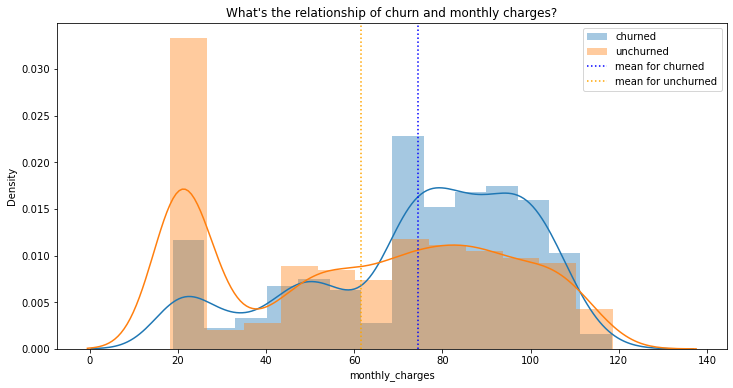

In [7]:
## does a levene test for comparing variance, creates a boolean flag that is passed into the ttest for
## comparing the churned monthly charge and the unchurned monthly charge
## then plots the graphs for a visual


H0 = "monthly payments of churned is less than or equal to monthly payments of unchurned"
Ha = "monthly payments of churned is greater than monthly payments of unchurned"
alpha = .025

#compare variances to know how to run the test
stat,pval = stats.levene(train_churned_df.monthly_charges,train_unchurned_df.monthly_charges)
stat,pval
if pval > 0.05:
    equal_var_flag = True
    print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
else:
    equal_var_flag = False
    print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))


t, p = stats.ttest_ind( train_churned_df.monthly_charges, train_unchurned_df.monthly_charges, equal_var = equal_var_flag )

if p > alpha or t < 0: #directionality, or if t is negative
    print("We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
else:
     print("We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))

plt.figure(figsize=(12,6))
plt.title("What's the relationship of churn and monthly charges?")
sns.distplot(train_churned_df.monthly_charges,label="churned")
sns.distplot(train_unchurned_df.monthly_charges,label="unchurned")
plt.axvline(train_churned_df.monthly_charges.mean(),color="blue",ls=":",label="mean for churned")
plt.axvline(train_unchurned_df.monthly_charges.mean(),color="orange",ls=":",label="mean for unchurned")
plt.legend()
plt.show()


> - Outcome: we do find enough evidence to statistically reject the null hypothesis ~~(monthly payments for those who churn are less than or equal to those who have not churned)~~

> - **Question 3 -** 
> - Which service provided has the highest churn?

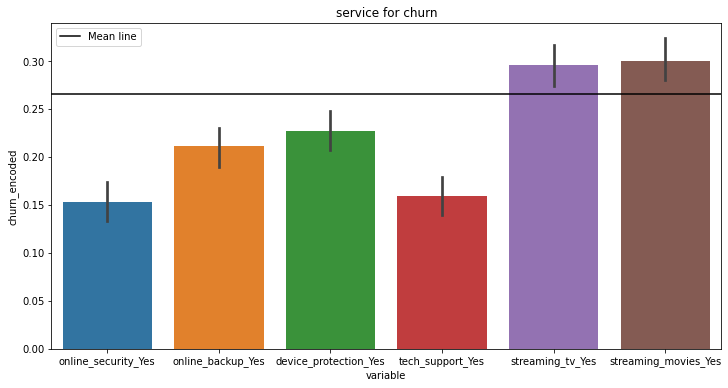

variable
device_protection_Yes    0.227242
online_backup_Yes        0.210953
online_security_Yes      0.153409
streaming_movies_Yes     0.299820
streaming_tv_Yes         0.296319
tech_support_Yes         0.159444
Name: churn_encoded, dtype: float64
-----------------
variable
streaming_movies_Yes    0.29982
Name: churn_encoded, dtype: float64


In [8]:
## creates a melt based on services provided and produced a chart based on the mean of churn for each category in services

service_list =['online_security_Yes', 'online_backup_Yes',
       'device_protection_Yes', 'tech_support_Yes', 'streaming_tv_Yes',
       'streaming_movies_Yes',"churn_encoded"]
melt = train_df[service_list]
melt = melt.melt(id_vars="churn_encoded")
melt = melt[melt.value == 1 ]
plt.figure(figsize=(12,6))
sns.barplot(x=melt.variable, y=melt.churn_encoded,)
plt.title("service for churn")
plt.axhline(train_df.churn_encoded.mean(), label="Mean line",color="black")
plt.legend()
plt.show()
print(melt.groupby("variable")["churn_encoded"].mean())
print("-----------------")
print(melt.groupby("variable")["churn_encoded"].mean().nlargest(1))

> - Outcome: Here we can see that those who subscribe to streaming movies (and TV) are services subscribed to the most by those who churn.


> - **Question 4 -** 
> - When (in terms of tenure) are people most likely to churn?

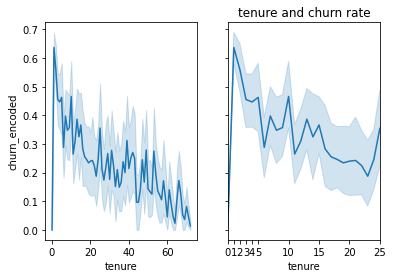

In [9]:
## creates two subplots that are of the churn ratio over time. the first is all of the time period provided in the data
## the second is "zoomed in" on the first 2 years (25 periods)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.lineplot(x=train_df["tenure"], y=train_df[prediction_col], data=train_df, ax=ax1)
plt.title(f"tenure and churn rate")

second_plt =sns.lineplot(x=train_df["tenure"], y=train_df[prediction_col], data=train_df, ax=ax2)
plt.title("tenure and churn rate")
second_plt.set_xlim(0,24)
plt.xticks([0,1,2,3,4,5,10,15,20,25])
plt.show()

> - Outcome: highest churn to be found at the first month, a bump near the 1 year contract end, as well as a rise again near the 2 year contract term

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---

In [10]:
##find the baseline of churn based on mode
baseline_predict = train_df[prediction_col].mode()[0]
(train_df[prediction_col] == baseline_predict).mean()

print(f"{baseline_predict} <--- mode of survived in training data / baseline prediction")
print(f"{(train_df[prediction_col] == baseline_predict).mean() * 100 :.2f}% <--- accuracy of baseline prediciton in training data")


0 <--- mode of survived in training data / baseline prediction
73.47% <--- accuracy of baseline prediciton in training data


### **73.47% baseline prediction accuracy on training data**

-
-
-
-
-
-
-
-
-
-

we see there are a lot of categories, so we will go through and perform an independance test. we'll use pval to drop those with "statistically significant" likelyhood of dependance. 

we will be using relatively low pval due to wanting only the most independant features

In [11]:
## in an attempt to reduce features i go through and remove categorical features that have low independance of Churn
## to reduce further i remove the bottom 25% through evaluation of Chi^2 values

cat_df = pd.DataFrame({"col_name":[],"p_val":[],"chi2_val":[]})
for iter1 in cat_vars:
    #if iter1 != "churn":
        
    var_x = train_df[iter1]
    var_y = train_df.churn_encoded
    data = train_df
    #threshold_line = train_df.churn.mean()
        
    alpha = .05
    df1 = pd.crosstab(var_x,var_y)
    H0 = (f"{var_x.name} is independant of being {var_y.name}")
    H1 = (f"{var_x.name} is not independant of being {var_y.name}")
    chi2, p, degf, expected = stats.chi2_contingency(df1)
    #if p>alpha:
        #print(f"{chi2}=chi2 | due to p={p:.5f} > α={alpha} we fail to reject ({H0})")
    #else:
        #print(f"{chi2}=chi2 | due to p = {p:.5f} < α = {alpha} we reject ({H0})")
    
    #plt.title(f"{var_y.name} relation {var_x.name}")
    #sns.barplot(x=var_x, y=var_y, data=df)
    #plt.axhline(threshold_line, label="Threshold line")
    #plt.show()
    
    cat_df.loc[len(cat_df.index)] = [var_x.name,p,chi2]
cat_dep_df = cat_df[cat_df["p_val"] < .05]
cat_dep_df.chi2_val.describe()

cat_dep_df["chi_cat"] = \
    np.where(cat_dep_df.chi2_val < cat_dep_df.chi2_val.quantile(.25),"very low",
    np.where(cat_dep_df.chi2_val < cat_dep_df.chi2_val.quantile(.5),"low",
    np.where(cat_dep_df.chi2_val < cat_dep_df.chi2_val.quantile(.75),"high",
    np.where(cat_dep_df.chi2_val < cat_dep_df.chi2_val.quantile(.9),"very high",
    "extreme high"))))
cat_high_dep_df = cat_dep_df[cat_dep_df.chi2_val > cat_dep_df.chi2_val.quantile(.25)]
cat_high_dep_df = cat_high_dep_df[cat_high_dep_df.col_name != "churn_encoded"]


In [12]:
##setting the data sets based on features i want to include
X_train = train_df[train_df.columns.intersection([ele for ele in cat_high_dep_df.col_name])]
y_train = train_df[prediction_col]

X_validate = validate_df[validate_df.columns.intersection([ele for ele in cat_high_dep_df.col_name])]
y_validate = validate_df[prediction_col]

X_test = test_df[test_df.columns.intersection([ele for ele in cat_high_dep_df.col_name])]
y_test = test_df[prediction_col]

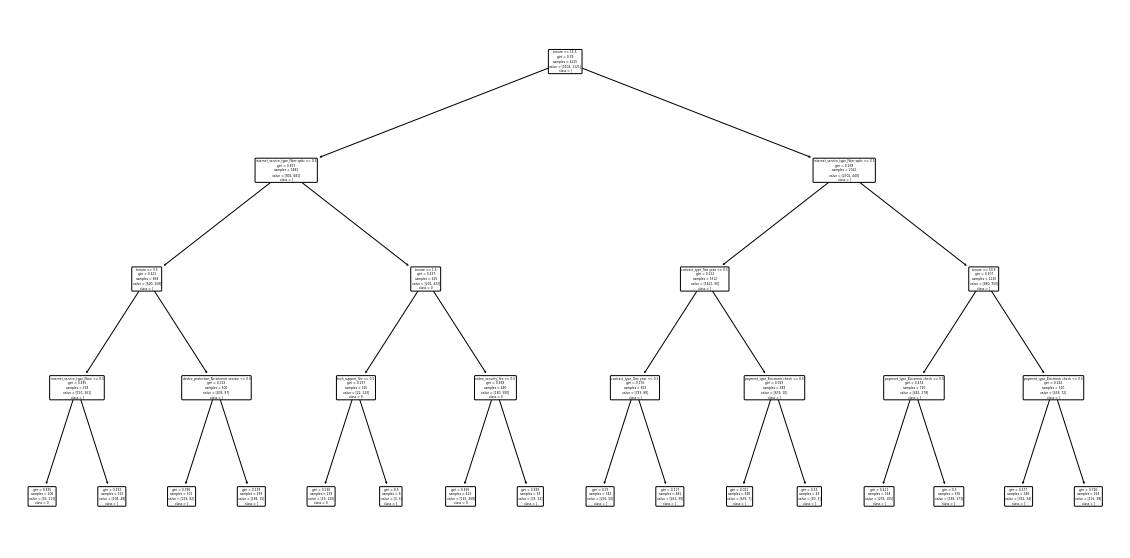

---------------
      0    1
0  2847  257
1   620  501 << training confusion matrix
---------------
Accuracy of Decision Tree classifier on training set: 0.79
---------------
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3104
           1       0.66      0.45      0.53      1121

    accuracy                           0.79      4225
   macro avg       0.74      0.68      0.70      4225
weighted avg       0.78      0.79      0.78      4225
 	 classification report on training set

-----------------------

     0    1
0  951   84
1  191  183 <<validate confusion matrix
----------
Accuracy of Decision Tree classifier on validate set: 0.80
----------
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1035
           1       0.69      0.49      0.57       374

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg   

In [13]:
## doing a basic decison tree classification, the number for depth was determined in previous class work i've done
## fits the model, plots it, predicts off the training, and produces results (classification and confusion matrix)

clf = DecisionTreeClassifier(max_depth= 4, random_state= 123, criterion="gini")
clf = clf.fit(X_train,y_train)

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X_train.columns, class_names=str(clf.classes_), rounded=True)
plt.show()

y_pred_train_dt = clf.predict(X_train)
y_pred_dt_proba = clf.predict_proba(X_train)
#print(y_pred_dt_proba[0:5],"decision tree")

labels = sorted(y_train.unique())
TN3, FP3, FN3, TP3 = confusion_matrix(y_train,y_pred_train_dt).ravel()
print("---------------")
print(pd.DataFrame(confusion_matrix(y_train,y_pred_train_dt), index=labels, columns=labels), "<< training confusion matrix")
print("---------------")
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print("---------------")
print(classification_report(y_train,y_pred_train_dt), "\t classification report on training set")
print("\n-----------------------\n")
y_pred_val_dt = clf.predict(X_validate)
print(pd.DataFrame(confusion_matrix(y_validate,y_pred_val_dt),index=labels,columns=labels),"<<validate confusion matrix")
print("----------")
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'.format(clf.score(X_validate, y_validate)))
print("----------")
print(classification_report(y_validate, y_pred_val_dt), "\t classification report on validate set")

-
-
-
-
-
-
-
-
-
-

[[2835  269]
 [ 545  576]] << training confusion matrix
--------
Accuracy of random forest classifier on training set: 0.81
--------
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      3104
           1       0.68      0.51      0.59      1121

    accuracy                           0.81      4225
   macro avg       0.76      0.71      0.73      4225
weighted avg       0.80      0.81      0.80      4225
 	 training classification report

----------

[[941  94]
 [180 194]] confusion matrix
Accuracy of random forest classifier on validate set: 0.81
----------
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409
 	 validate classification report


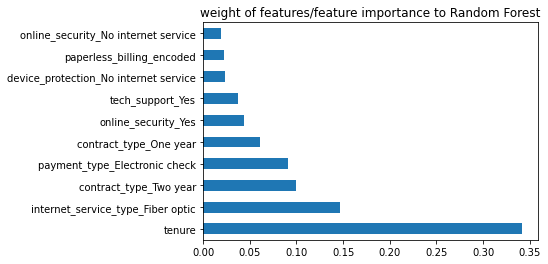

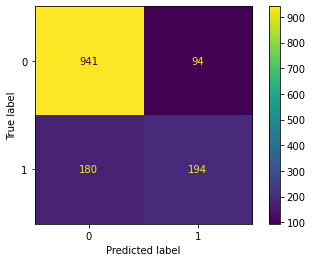

In [14]:
## random forest classifier, i played with the values until i settled on these
## fits the data, predicts on the training, and runs classification and confusion reports
## also plots the most weight of the top 10 features with a confusion matrix display below it

rf = RandomForestClassifier(bootstrap=True,
                         class_weight=None,
                         criterion="gini",
                         min_samples_leaf=5,
                         n_estimators=100,
                         max_depth=7,
                         random_state=123
                         )
rf.fit(X_train,y_train)

y_pred_rf = rf.predict(X_train)
y_pred_rf_proba = rf.predict_proba(X_train)

pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(10).plot(kind='barh')
plt.title("weight of features/feature importance to Random Forest")

print(confusion_matrix(y_train, y_pred_rf), "<< training confusion matrix")
TN, FP, FN, TP = confusion_matrix(y_train,y_pred_rf).ravel()
print("--------")
print('Accuracy of random forest classifier on training set: {:.2f}'.format(rf.score(X_train, y_train)))
print("--------")
print(classification_report(y_train, y_pred_rf),"\t training classification report")
print("\n----------\n")
y_pred_rf_val = rf.predict(X_validate)
print(confusion_matrix(y_validate, y_pred_rf_val), "confusion matrix")
print('Accuracy of random forest classifier on validate set: {:.2f}'.format(rf.score(X_validate, y_validate)))
print("----------")
y_pred_rf_val = rf.predict(X_validate)
print(classification_report(y_validate, y_pred_rf_val),"\t validate classification report")

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_validate, y_pred_rf_val), display_labels=rf.classes_)
disp.plot()
plt.show()

-
-
-
-
-
-
-
-
-
-

In [15]:
## logistic regression classifier, played with values until i found some i liked
## produces confusion and classification reports

logreg = LogisticRegression(C=.1)#, class_weight={0:1, 1:99}, random_state=123, intercept_scaling=1, solver='lbfgs', max_iter=1000000000)
logreg.fit(X_train,y_train)


y_pred_train_array = logreg.predict(X_train)
print(confusion_matrix(y_train, y_pred_train_array), "<< train confusion matrix")
print("----------")
print('Accuracy of Logistic Regression on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print("----------")
print(classification_report(y_train, y_pred_train_array),"\t train classification")
y_pred_logreg_val = logreg.predict(X_validate)
print("\n ------------------------------ \n")
print(confusion_matrix(y_validate, y_pred_logreg_val),"<< validate confusion matrix")
print("----------")
print('Accuracy of Logistic Regression on validate set: {:.2f}'.format(logreg.score(X_validate, y_validate)))
print("----------")
print(classification_report(y_validate, y_pred_logreg_val),"\t validate classification")

[[2792  312]
 [ 563  558]] << train confusion matrix
----------
Accuracy of Logistic Regression on training set: 0.79
----------
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      3104
           1       0.64      0.50      0.56      1121

    accuracy                           0.79      4225
   macro avg       0.74      0.70      0.71      4225
weighted avg       0.78      0.79      0.78      4225
 	 train classification

 ------------------------------ 

[[930 105]
 [169 205]] << validate confusion matrix
----------
Accuracy of Logistic Regression on validate set: 0.81
----------
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409
 	 validate classification


-
-
-
-
-
-
-
-
-
-

## Opting to use RandomForest for the final test predictions

In [16]:
## running the test set using my randomforest classifier
## produces confusion, classifification report as well as probabilities

y_pred_rf_test = rf.predict(X_test)
y_proba_rf_test = rf.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred_rf_test), "confusion matrix")
print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))
print("----------")
print(classification_report(y_test, y_pred_rf_test),"\t test classification report")


[[927 108]
 [168 206]] confusion matrix
Accuracy of random forest classifier on test set: 0.80
----------
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409
 	 test classification report


The recall and precision are less than i would like to see

In [22]:
#i keep everything in X_test to retain the index for match with customer_id and churn value
# removes the data that was not in it prior through tranposing and using tail, and pushes that out a csv

X_test["0_proba"] = pd.DataFrame(y_proba_rf_test,columns=["0_proba","1_proba"])["0_proba"].values
X_test["1_proba"] = pd.DataFrame(y_proba_rf_test,columns=["0_proba","1_proba"])["1_proba"].values
X_test["prediction"] = y_pred_rf_test
X_test["customer_id"],X_test["churn_encoded"], = prepare_df.customer_id,prepare_df.churn_encoded
X_test.T.tail(5).T.to_csv("predictions.csv")
X_test.T.tail(5).T

,0_proba,1_proba,prediction,customer_id,churn_encoded
3160,0.8611,0.1389,0,4531-AUZNK,0
1577,0.959171,0.040829,0,2296-DKZFP,0
6823,0.526717,0.473283,0,9692-TUSXH,1
3615,0.574919,0.425081,0,5129-JLPIS,0
882,0.297611,0.702389,1,1273-MTETI,1
...,...,...,...,...,...
1097,0.589233,0.410767,0,1597-FZREH,1
6441,0.412703,0.587297,1,9117-SHLZX,1
5985,0.98419,0.01581,0,8441-SHIPE,0
2452,0.972722,0.027278,0,3511-BFTJW,0


# Churn-Telco Classification Project

## Project Summary
<hr style="border-top: 10px white; margin-top: 1px; margin-bottom: 1px"></hr>

#### Project Objectives
> - Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook report.
> - Create modules (acquire.py, prepare.py) that make your process repeateable and your report (notebook) easier to read and follow.
> - Ask exploratory questions of your data that will help you understand more about the attributes and drivers of customers churning. Answer questions through charts and statistical tests.
> - Construct a model to predict customer churn using classification techniques.
> - Refine your work into a Report, in the form of a jupyter notebook, that you will walk through in a 5 minute presentation to a group of collegues and managers about the work you did, why, goals, what you found, your methdologies, and your conclusions.
> - ABe prepared to answer panel questions about your code, process, findings and key takeaways, and model.

#### Business Goals
> - Find drivers for customer churn at Telco. Why are customers churning?
> - Construct a ML classification model that accurately predicts customer churn.
> - Deliver a report that a non-data scientist can read through and understand what steps were taken, why and what was the outcome?

#### Audience
> - Your target audience for your notebook walkthrough is your direct manager and their manager. This should guide your language and level of explanations in your walkthrough.

#### Project Deliverables
> - This Readme.md
> - A final report notebook  (.ipynb)
> - Acquire & Prepare Modules (.py)
> - Predictions (.csv)
> - A final report notebook presentation

#### Project Context
> - The Telco dataset I'm using came from the Codeup database.

#### Data Dictionary

|Target                    |Datatype               |Definition|
|:-------                  |:--------              |:----------|
| churn                    | 7043 non-null: object | churn - yes, no |
|                          |                       | 
| **Feature**              | **Datatype**          | **Definition** |
| payment_type_id          |7043 non-null: int64   | payment type encoded |
| internet_service_type_id |7043 non-null: int64   | internet service type encoded |
| contract_type_id         |7043 non-null: int64   | contract type encoded |
| customer_id              |7043 non-null: object  | unique key for customers |
| gender                   |7043 non-null: object  | gender - M/F |
| senior_citizen           |7043 non-null: int64   | senior citizen - hot encoded |
| partner                  |7043 non-null: object  | partner - Y/N |
| dependents               |7043 non-null: object  | dependents - Y/N |
| tenure                   |7043 non-null: int64   | tenure - count by months |
| phone_service            |7043 non-null: object  | phone_service - Y/N |
| multiple_lines           |7043 non-null: object  | multiple_lines - Y/N |
| online_security          |7043 non-null: object  | online_security - Y/N |
| online_backup            |7043 non-null: object  | online_backup - Y/N |
| device_protection        |7043 non-null: object  | device_protection - Y/N |
| tech_support             |7043 non-null: object  | tech_support - Y/N |
| streaming_tv             |7043 non-null: object  | streaming_tv - Y/N |
| streaming_movies         |7043 non-null: object  | streaming_movies - Y/N |
| paperless_billing        |7043 non-null: object  | paperless_billing - Y/N |
| monthly_charges          |7043 non-null: float64 | monthly charge amount |
| total_charges            |7043 non-null: object  | total charged to customer |
| churn                    |7043 non-null: object  | churn - Y/N |
| contract_type            |7043 non-null: object  | categorical, string for encoded |
| internet_service_type    |7043 non-null: object  | categorical, string for encoded |
| payment_type             |7043 non-null: object  | categorical, string for encoded |

#### Initial Hypotheses

> - **Hypothesis 1 -**
> - alpha = .05
> - $H_0$: Is churn independant of payment type. $\mu_{churn}$ independent $\mu_{payment type}$ (pval > alpha).  
> - $H_a$: Rejection of Null $\mu_{virginica}$ ~~independent~~  $\mu_{versicolor}$ (pval <= alpha). 
> - Outcome: Sufficient evidence to reject our null hypothesis

> - **Hypothesis 2 -** 
> - alpha = .025
> - $H_0$: Is monthly payment greater for those who churned and than those who have not churn $\mu_{monthly payment (churned)} > \mu_{monthly payment (retained)}$.  
> - $H_a$: Rejection of null $\mu_{monthly payment (churned)} <= \mu_{monthly payment (retained)}$. 
> - Outcome: Sufficent evidence to reject our null hypothesis

> - **Question 3 -** 
> - Which service provided has the highest churn?
> - Outcome: Movie Streaming (and TV streaming close second).

> - **Question 4 -** 
> - When (in terms of tenure) are people most likely to churn?
> - Outcome: Within the first 3 months, the first month being the highest.

<hr style="border-top: 10px white; margin-top: 1px; margin-bottom: 1px"></hr>

### Executive Summary - Conclusions & Next Steps
<hr style="border-top: 10px white; margin-top: 1px; margin-bottom: 1px"></hr>

> - I found that of the classification models I created, LogisticRegression, DecisionTree, and RandomForest predicted the likelyhood of Churn equally well.
> - I chose my RandomForest model as my best model with an 80% accuracy rate for predicting my target value, Churn. This model outperformed my baseline score of 73% accuracy, so it has a little value.
> - Some initial exploration and statistical testing revealed that engineering some new features around tenure, services, and internet type I might help my models predict with even more accuracy, and with more time, I would like to test this hypothesis.

<hr style="border-top: 10px white; margin-top: 1px; margin-bottom: 1px"></hr>

### Pipeline Stages Breakdown

<hr style="border-top: 10px white; margin-top: 1px; margin-bottom: 1px"></hr>

##### Plan
- Create README.md with data dictionary, project and business goals, come up with initial hypotheses.
- Acquire data from the Codeup Database and create a function to automate this process. Save the function in an acquire.py file to import into the Final Report Notebook.
- Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process, store the function in a prepare.py module, and prepare data in Final Report Notebook by importing and using the funtion.
- Ask four questions, two of which are to be statistical  and two are to be visualized with context provided.
- Clearly define two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- Establish a baseline accuracy and document well.
- Train three different classification models.
- Evaluate models on train and validate datasets.
- Choose the model with that performs the best and evaluate that single model on the test dataset.
- Create csv file with the customer id, the probability of the target values, and the model's prediction for churn for each observation in my test dataset.
- Document conclusions, takeaways, and next steps in the Final Report Notebook.

___

##### Plan -> Acquire
> - Store functions that are needed to acquire data from the measures and species tables from the telco database on the Codeup data science database server; make sure the acquire.py module contains the necessary imports to run my code.
> - The final function will return a pandas DataFrame.
> - Import the acquire function from the acquire.py module and use it to acquire the data in the Final Report Notebook.
> - Complete some initial data summarization (`.info()`, `.describe()`, `.value_counts()`, ...).
> - Plot distributions of individual variables.
___

##### Plan -> Acquire -> Prepare
> - Store functions needed to prepare the telco data; make sure the module contains the necessary imports to run the code. The final function should do the following:
    - Split the data into train/validate/test.
    - Handle any missing values.
    - Handle erroneous data and/or outliers that need addressing.
    - Encode variables as needed.
    - Create any new features, if made for this project.
> - Import the prepare function from the prepare.py module and use it to prepare the data in the Final Report Notebook.
___

##### Plan -> Acquire -> Prepare -> Explore
> - Answer key questions, my hypotheses, and figure out the features that can be used in a classification model to best predict the target variable, species. 
> - Run at least 2 statistical tests in data exploration. Document my hypotheses, set an alpha before running the tests, and document the findings well.
> - Create visualizations and run statistical tests that work toward discovering variable relationships (independent with independent and independent with dependent). The goal is to identify features that are related to species (the target), identify any data integrity issues, and understand 'how the data works'. If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.
> - Summarize my conclusions, provide clear answers to my specific questions, and summarize any takeaways/action plan from the work above.
___

##### Plan -> Acquire -> Prepare -> Explore -> Model
> - Establish a baseline accuracy to determine if having a model is better than no model and train and compare at least 3 different models. Document these steps well.
> - Train (fit, transform, evaluate) multiple models, varying the algorithm and/or hyperparameters you use.
> - Compare evaluation metrics across all the models you train and select the ones you want to evaluate using your validate dataframe.
> - Feature Selection (after initial iteration through pipeline): Are there any variables that seem to provide limited to no additional information? If so, remove them.
> - Based on the evaluation of the models using the train and validate datasets, choose the best model to try with the test data, once.
> - Test the final model on the out-of-sample data (the testing dataset), summarize the performance, interpret and document the results.
___

##### Plan -> Acquire -> Prepare -> Explore -> Model -> Deliver
> - Introduce myself and my project goals at the very beginning of my notebook walkthrough.
> - Summarize my findings at the beginning like I would for an Executive Summary. (Don't throw everything out that I learned from Storytelling) .
> - Walk Codeup Data Science Team through the analysis I did to answer my questions and that lead to my findings. (Visualize relationships and Document takeaways.) 
> - Clearly call out the questions and answers I am analyzing as well as offer insights and recommendations based on my findings.

<hr style="border-top: 10px white; margin-top: 1px; margin-bottom: 1px"></hr>

### Reproduce My Project

<hr style="border-top: 10px white; margin-top: 1px; margin-bottom: 1px"></hr>

You will need your own env file with database credentials along with all the necessary files listed below to run my final project notebook. 
- Read this README.md
- Download the aquire.py, prepare.py, and final_report.ipynb files into your working directory
- Add your own env file to your directory. (user, password, host)
- Run the final_report.ipynb notebook